## Gerekli Kütüphaneler
- Grafın incelenebilmesi için kullanılan networkx gibi kütüphaneler projeye dahil edilmelidir

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import collections
import community as community_louvain
import seaborn as sns
from networkx.algorithms import community
from pyvis.network import Network
import time
import random
from random import randint
import requests
import gzip
import os

## Veri Setinin İndirilmesi ve NetworkX Kütüphanesi ile Import Edilmesi
1. Veri seti "http://snap.stanford.edu/data/web-Google.txt.gz" adresinden indirilir. (web-Google grafı)
2. ".gz" uzantılı dosyanın içeriği çıkartılır.
3. G değişkenine yönlü graf olarak aktarılır.

In [22]:
url = "http://snap.stanford.edu/data/web-Google.txt.gz"

gz_file_path = "web-Google.txt.gz"
txt_file_path = "web-Google.txt"

if not os.path.exists(gz_file_path):
    print(f"İndiriliyor {url}...")
    response = requests.get(url, stream=True)
    with open(gz_file_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)
    print("İndirme Tamamlandı!")
else:
    print(f"Dosya {gz_file_path} dizinde mevcut.")

if not os.path.exists(txt_file_path):
    print(f"Çıkarılıyor {gz_file_path}...")
    with gzip.open(gz_file_path, 'rb') as f_in:
        with open(txt_file_path, 'wb') as f_out:
            f_out.write(f_in.read())
    print("Çıkarılma Tamamlandı!")
else:
    print(f"Dosya {txt_file_path} dizinde mevcut.")

print("Yönlü graf oluşturuluyor...")
G = nx.DiGraph()

with open(txt_file_path, 'r') as f:
    for line in f:
        line = line.strip()
        if line.startswith('#'):
            continue
        nodes = line.split()
        if len(nodes) >= 2:
            from_node = int(nodes[0])
            to_node = int(nodes[1])
            G.add_edge(from_node, to_node)

print(f"Graf başarıyla oluşturuldu!")
print(f"Düğüm sayısı: {G.number_of_nodes()}")
print(f"Kenar sayısı: {G.number_of_edges()}")

Dosya web-Google.txt.gz dizinde mevcut.
Dosya web-Google.txt dizinde mevcut.
Yönlü graf oluşturuluyor...
Graf başarıyla oluşturuldu!
Düğüm sayısı: 875713
Kenar sayısı: 5105039


## Graf Örnekleme (Graph Sampling) (Tercihi-Önerilir)
- Graf çok fazla düğüm ve kenar içerdiğinden dolayı üzerinde çalışılırken işlemlerin hızlanması açısından örnekleme yapılmasına ihtiyaç duyulmuştur.
#### Strateji:
1. En yüksek PageRank skoruna sahip düğüm seçilir.
2. En yüksek PageRank'a sahip düğümden başlanarak BFS algoritması ile istenen node sayısına ulaşılana kadar graf'da gezilir ve yeni graf oluşturulur.
3. 5.000-10.000 düğümlük bir alt graf oluşturacağız ("target_nodes" değişkeni istenen boyuta göre değistirilebilir, PyVis ile görselleştirme yapılacaksa 500-1000 diğer işlemler için 5000-10.000 arasi verilmesi tavsiye edilir.)

In [23]:
from collections import deque

def bfs_sample_pagerank_directed(G, sample_size):
    pagerank = nx.pagerank(G)
    start_node = max(pagerank, key=pagerank.get)
    sampled_nodes = set()
    queue = deque([start_node])

    while queue and len(sampled_nodes) < sample_size:
        node = queue.popleft()
        if node not in sampled_nodes:
            sampled_nodes.add(node)
            neighbors = list(G.successors(node))
            queue.extend(neighbors)

    return G.subgraph(sampled_nodes).copy()

G_sampled = bfs_sample_pagerank_directed(G, 1200) # istenen sayıya göre değiştirilebilir

G = G_sampled.copy()

## Temel İstatistikler

#### 1. Düğüm ve Kenar Sayısı

In [4]:
print(f"Düğüm Sayısı: {G.number_of_nodes()}")
print(f"Kenar Sayısı: {G.number_of_edges()}")

Düğüm Sayısı: 6000
Kenar Sayısı: 40816


#### 2. İç ve dış derece

In [5]:
in_degrees = dict(G.in_degree())
out_degrees = dict(G.out_degree())
degree = dict(G.degree)

print(f"Ortalama Derece: {np.mean(list(degree.values())):.3f}")
print(f"Ortalama İç Derece: {np.mean(list(in_degrees.values())):.3f}")
print(f"Ortalama Dış Derece: {np.mean(list(out_degrees.values())):.3f}")

Ortalama Derece: 13.605
Ortalama İç Derece: 6.803
Ortalama Dış Derece: 6.803


#### 3. Ağ Yoğunluğu

In [6]:
print(f"Ağ Yoğunluğu: {nx.density(G):.8f}")

Ağ Yoğunluğu: 0.00113397


#### 4. Bağlantı güçleri

In [7]:
strong_components = list(nx.strongly_connected_components(G))
weak_components = list(nx.weakly_connected_components(G))

print(f"Güçlü Bağlı Bileşenler sayısı: {len(strong_components)}")
print(f"Zayıf Bağlı Bileşenler sayısı: {len(weak_components)}")

largest_strong = max(strong_components, key=len)
largest_weak = max(weak_components, key=len)

print(f"En büyük Güçlü Bağlı Bileşen boyutu: {len(largest_strong)}")
print(f"En büyük Zayıf Bağlı Bileşen boyutu: {len(largest_weak)}")

Güçlü Bağlı Bileşenler sayısı: 1334
Zayıf Bağlı Bileşenler sayısı: 1
En büyük Güçlü Bağlı Bileşen boyutu: 4049
En büyük Zayıf Bağlı Bileşen boyutu: 6000


#### 5. Derece Dağılım Analizi

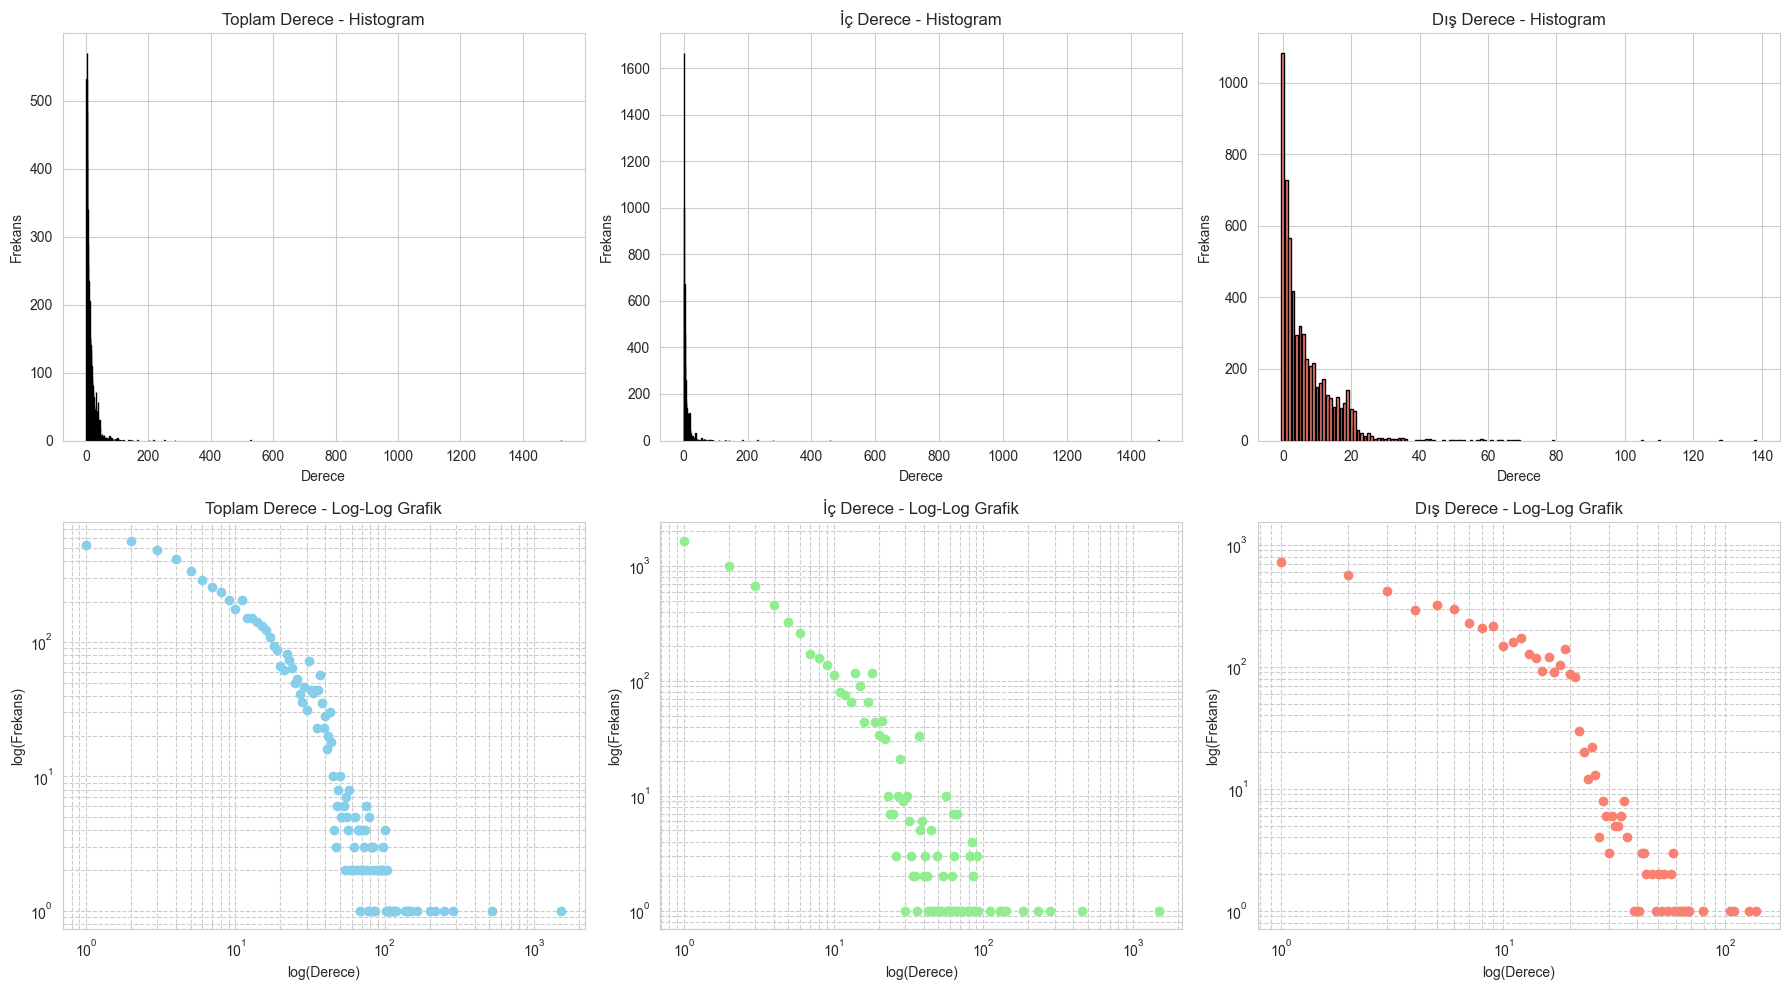

In [8]:
toplam_derece_listesi = [d for n, d in G.degree()]
ic_derece_listesi = [d for n, d in G.in_degree()]
dis_derece_listesi = [d for n, d in G.out_degree()]

dereceler = [
    ("Toplam Derece", toplam_derece_listesi, 'skyblue'),
    ("İç Derece", ic_derece_listesi, 'lightgreen'),
    ("Dış Derece", dis_derece_listesi, 'salmon')
]

fig, axs = plt.subplots(2, 3, figsize=(18, 10))

for i, (baslik, derece_listesi, renk) in enumerate(dereceler):
    derece_sayimi = collections.Counter(derece_listesi)
    derece, frekans = zip(*sorted(derece_sayimi.items()))

    axs[0, i].bar(derece, frekans, width=0.8, color=renk, edgecolor='black')
    axs[0, i].set_title(f"{baslik} - Histogram")
    axs[0, i].set_xlabel("Derece")
    axs[0, i].set_ylabel("Frekans")
    axs[0, i].grid(True)

    axs[1, i].loglog(derece, frekans, marker='o', linestyle='None', color=renk)
    axs[1, i].set_title(f"{baslik} - Log-Log Grafik")
    axs[1, i].set_xlabel("log(Derece)")
    axs[1, i].set_ylabel("log(Frekans)")
    axs[1, i].grid(True, which="both", ls="--")

plt.tight_layout()
plt.show()

### Topluluk Analizi (Community Detection)


Tespit edilen topluluk sayısı: 43
En büyük topluluk boyutu: 598
En küçük topluluk boyutu: 6
Ortalama topluluk boyutu: 139.53
Louvain hesaplama süresi: 0.37 saniye
Modülerlik puanı: 0.8635


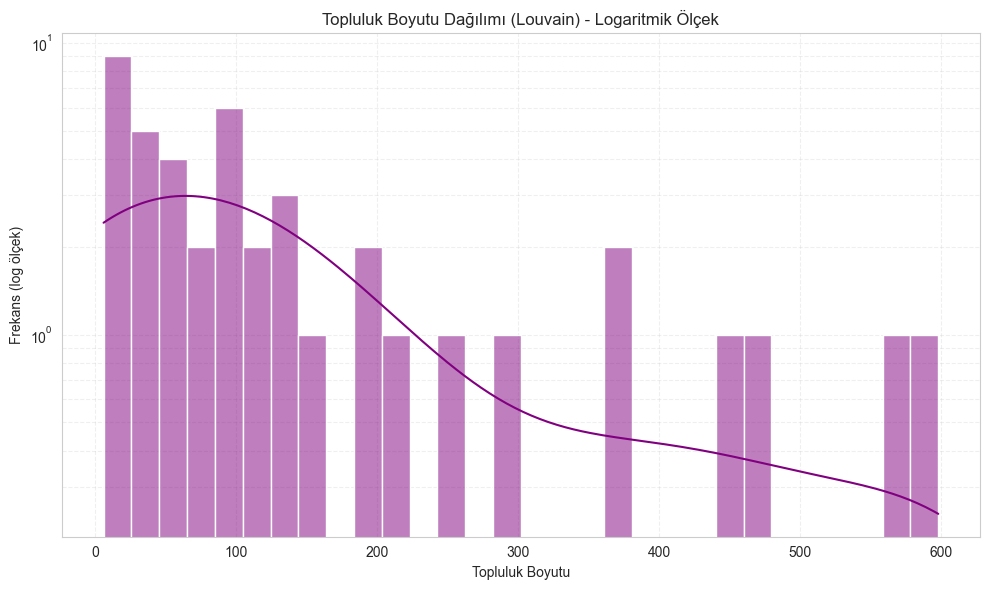


Görselleştirilen topluluk ID: 21
Topluluk boyutu: 137


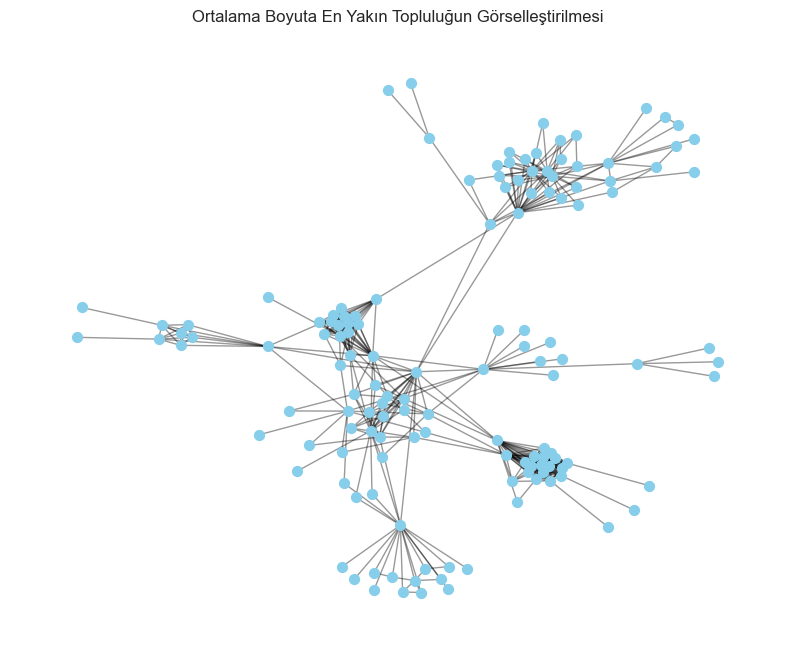

In [9]:
from collections import Counter

G_community_undirected = G.to_undirected()

start_time_louvain = time.time()
detected_communities_louvain = community.louvain_communities(G_community_undirected, seed=42)
end_time_louvain = time.time()

communities_as_list = list(detected_communities_louvain)

print(f"Tespit edilen topluluk sayısı: {len(communities_as_list)}")

community_sizes_list = [len(c) for c in communities_as_list]
print(f"En büyük topluluk boyutu: {max(community_sizes_list)}")
print(f"En küçük topluluk boyutu: {min(community_sizes_list)}")
print(f"Ortalama topluluk boyutu: {np.mean(community_sizes_list):.2f}")
print(f"Louvain hesaplama süresi: {end_time_louvain - start_time_louvain:.2f} saniye")

calculated_modularity = community.modularity(G_community_undirected, communities_as_list)
print(f"Modülerlik puanı: {calculated_modularity:.4f}")

# Histogram (logaritmik y-ekseni)
plt.figure(figsize=(10, 6))
sns.histplot(community_sizes_list, kde=True, color='purple', bins=min(30, len(set(community_sizes_list))))
plt.yscale('log')  # y ekseni logaritmik
plt.title("Topluluk Boyutu Dağılımı (Louvain) - Logaritmik Ölçek")
plt.xlabel("Topluluk Boyutu")
plt.ylabel("Frekans (log ölçek)")
plt.grid(True, alpha=0.3, which='both', linestyle='--')
plt.tight_layout()
plt.show()

# Ortalama boyutta olan bir komunitenin gorsellestirilmesi
average_size = np.mean(community_sizes_list)
closest_idx = np.argmin([abs(len(c) - average_size) for c in communities_as_list])
selected_community = communities_as_list[closest_idx]

print(f"\nGörselleştirilen topluluk ID: {closest_idx}")
print(f"Topluluk boyutu: {len(selected_community)}")

community_subgraph = G_community_undirected.subgraph(selected_community)

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(community_subgraph, seed=42)  # sabit konumlar için seed
nx.draw_networkx_nodes(community_subgraph, pos, node_size=50, node_color='skyblue')
nx.draw_networkx_edges(community_subgraph, pos, alpha=0.4)
plt.title("Ortalama Boyuta En Yakın Topluluğun Görselleştirilmesi")
plt.axis('off')
plt.show()

Bu grafik web-google grafında bulunan çoğu komünite'nin düğüm sayısının 0 ila 50 arasında değiştiğini göstermektedir. Diğerlerinden farklı olarak 350-400 düğüm sayısına sahip bir adet komünite bulunmaktadır, bu komünite çekirdek etrafında oluşan bir komünitedir daha sonra gephi üzerinden görselleştirilecektir.

#### Toplulukların görselleştirilmesi
- Tespit edilen topluluklar her bir topluluk rastgele renkler ile temsil edilerek PyVis kütüphanesi ile görselleştirilmiştir. (Yüksek düğüm içeren graflar için Gephi kullanılması tavsiye edilir, graf örnekleme yapılırsa bu adım kullanılabilir tercih edilen target_node: 500-1.000)

In [24]:
G_undirected = G.to_undirected()
partition = community_louvain.best_partition(G_undirected)

colors_dict = {}
communities = {}
for node, community_id in partition.items():
    if community_id not in communities:
        communities[community_id] = []
    communities[community_id].append(node)

counter = 0
for community_id, nodes in communities.items():
    color = "#%06X" % randint(0, 0xFFFFFF)
    counter += 1
    for node in nodes:
        colors_dict[node] = color

colors = [colors_dict[node] for node in G.nodes()]

print(f"Number of communities detected: {counter}")

net = Network(height="750px", width="100%", notebook=True, bgcolor="#222222", font_color="white", cdn_resources='in_line')
net.from_nx(G)
net.force_atlas_2based()

# Apply the community colors
for node in net.nodes:
    node_id = node["id"]
    if node_id in colors_dict:
        node["color"] = colors_dict[node_id]

# Save and display the visualization
net.show("communities_visualization.html")

Number of communities detected: 27
communities_visualization.html


## Merkezilik Ölçümleri (Centrality Measures)


### 1. Derece merkeziliği (Degree centrality)

[(163075, 0.2537089514919153), (751384, 0.08784797466244373), (804489, 0.047507917986331055), (172133, 0.041840306717786296), (818382, 0.036006001000166696), (582124, 0.03350558426404401), (277876, 0.027504584097349558), (85266, 0.025170861810301717)]


Text(0, 0.5, 'Counts')

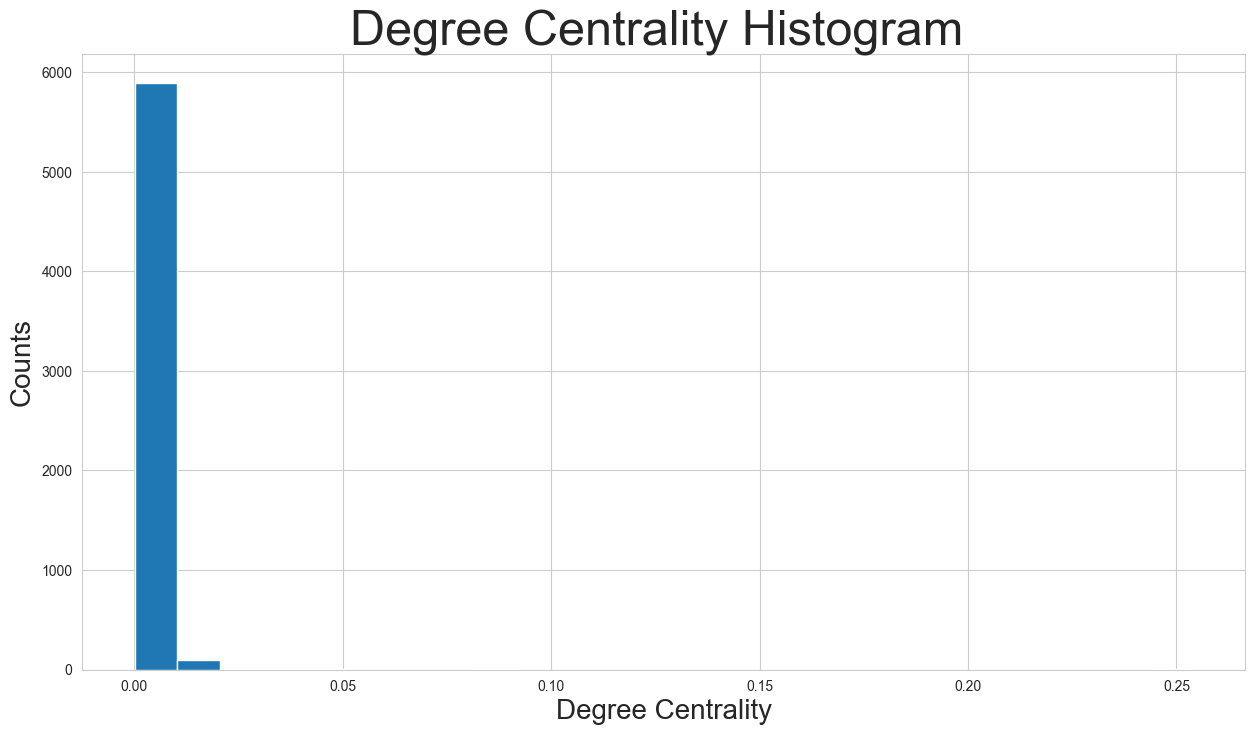

In [11]:
degree_centrality = nx.centrality.degree_centrality(G)
print((sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True))[:8])

plt.figure(figsize=(15, 8))
plt.hist(degree_centrality.values(), bins=25)
plt.title("Degree Centrality Histogram ", fontdict={"size": 35}, loc="center")
plt.xlabel("Degree Centrality", fontdict={"size": 20})
plt.ylabel("Counts", fontdict={"size": 20})

### 2. Arasındalık merkeziliği (Betweenness centrality)

[(163075, 0.5394377666701826), (751384, 0.15647079367076946), (164348, 0.14428010787000825), (484695, 0.10922252306743462), (172133, 0.07660146810216695), (639446, 0.06883643434648491), (818382, 0.06396081915650104), (624300, 0.06045737929816406)]


Text(0, 0.5, 'Counts')

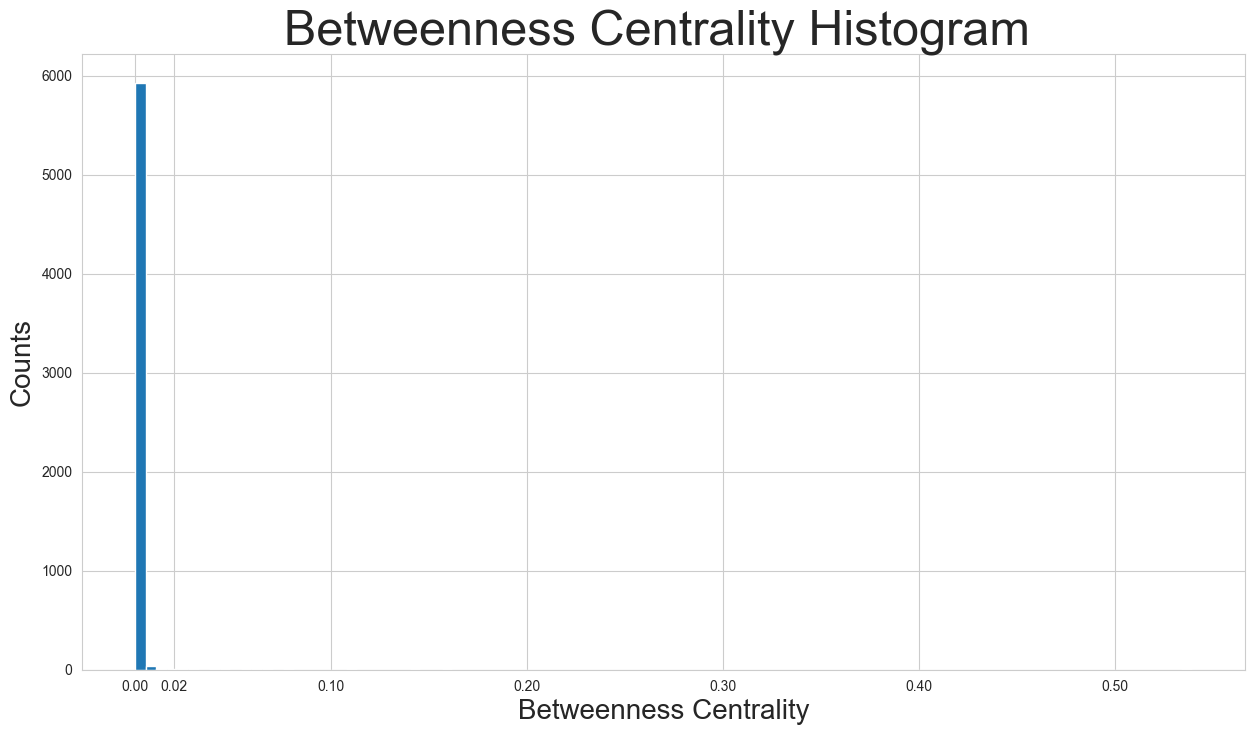

In [12]:
betweenness_centrality = nx.centrality.betweenness_centrality(G)
print((sorted(betweenness_centrality.items(), key=lambda item: item[1], reverse=True))[:8])

plt.figure(figsize=(15, 8))
plt.hist(betweenness_centrality.values(), bins=100)
plt.xticks(ticks=[0, 0.02, 0.1, 0.2, 0.3, 0.4, 0.5])  # set the x axis ticks
plt.title("Betweenness Centrality Histogram ", fontdict={"size": 35}, loc="center")
plt.xlabel("Betweenness Centrality", fontdict={"size": 20})
plt.ylabel("Counts", fontdict={"size": 20})

### 3. Yakınlık merkeziliği (Closeness centrality)

[(163075, 0.25868983025409054), (804489, 0.2040416760777577), (624300, 0.1947736678303581), (638031, 0.19455170353653434), (394956, 0.19310752334061096), (735770, 0.19222420250900366), (347085, 0.19140255887134341), (761488, 0.19105448119556145)]


Text(0, 0.5, 'Counts')

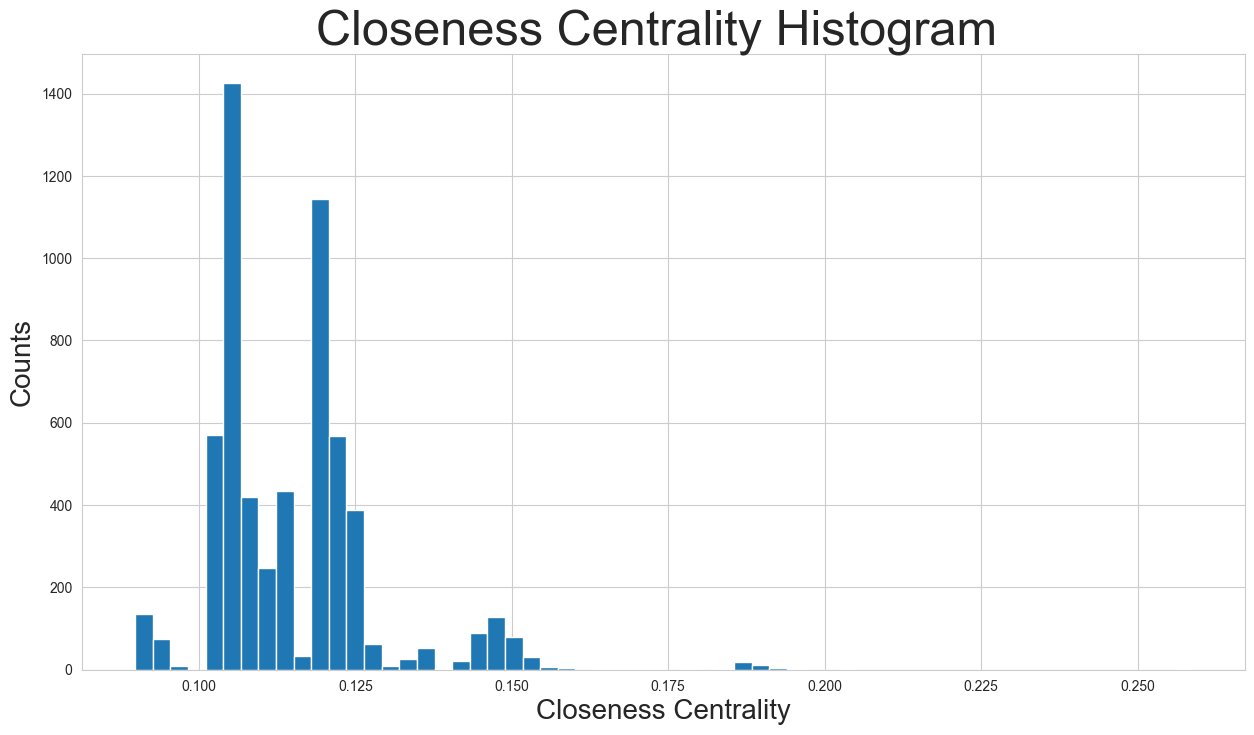

In [13]:
closeness_centrality = nx.centrality.closeness_centrality(G)
print((sorted(closeness_centrality.items(), key=lambda item: item[1], reverse=True))[:8])

plt.figure(figsize=(15, 8))
plt.hist(closeness_centrality.values(), bins=60)
plt.title("Closeness Centrality Histogram ", fontdict={"size": 35}, loc="center")
plt.xlabel("Closeness Centrality", fontdict={"size": 20})
plt.ylabel("Counts", fontdict={"size": 20})

## Yapısal Özellikler (Kümelenme, Yollar, Benzerlik)
- Bu bölümde grafın yapısal özellikleri incelenecektir
- Kümelenme katsayıları, yol uzunlukları ve düğüm benzerlikleri hesaplanacaktır
- Bu metrikler ağın düğümleri arasındaki ilişkileri ve topolojik yapıyı anlamak için önemlidir

### 1. Kümelenme Analizi
- Kümelenme katsayısı, bir düğümün komşularının birbirine ne kadar bağlı olduğunu gösterir
- Yüksek kümelenme katsayısı, düğümün komşularının yoğun bir şekilde birbirine bağlı olduğunu gösterir

Ortalama kümelenme katsayısı: 0.585922
Genel (transitivity) kümelenme katsayısı: 0.157108

En yüksek kümelenme katsayısına sahip 5 düğüm:
Düğüm 819248: 1.000000
Düğüm 262197: 1.000000
Düğüm 819270: 1.000000
Düğüm 688217: 1.000000
Düğüm 327771: 1.000000

En düşük kümelenme katsayısına sahip 5 düğüm (0 olmayanlar):
Düğüm 126985: 0.012821
Düğüm 706062: 0.009524
Düğüm 163075: 0.006920
Düğüm 357633: 0.006536
Düğüm 292873: 0.004329


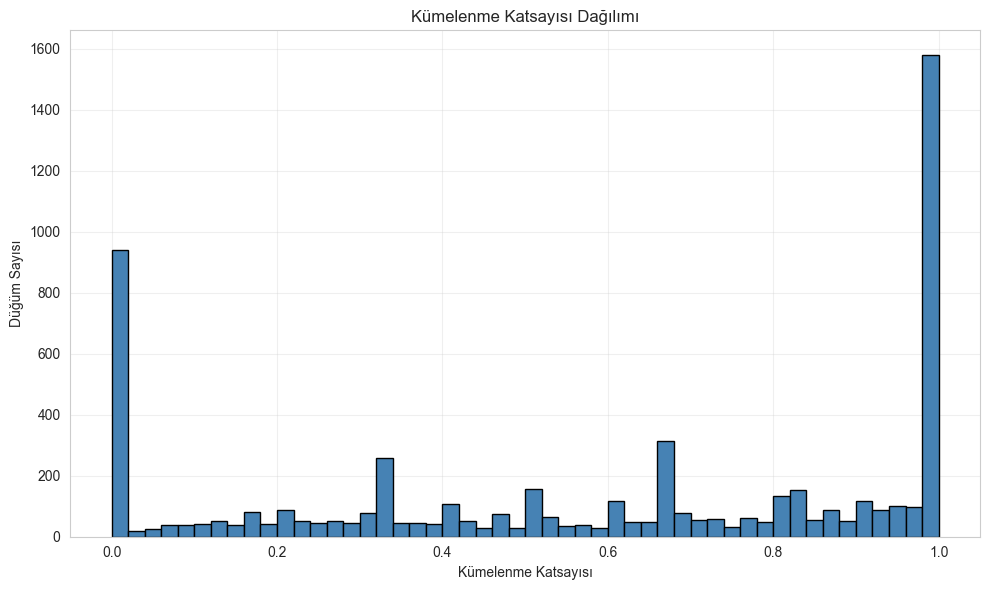

In [14]:
G_undirected = G.to_undirected()

clustering_coefficients = nx.clustering(G_undirected)
avg_clustering = nx.average_clustering(G_undirected)
transitivity = nx.transitivity(G_undirected)

print(f"Ortalama kümelenme katsayısı: {avg_clustering:.6f}")
print(f"Genel (transitivity) kümelenme katsayısı: {transitivity:.6f}")

sorted_clustering = sorted(clustering_coefficients.items(), key=lambda x: x[1], reverse=True)
print("\nEn yüksek kümelenme katsayısına sahip 5 düğüm:")
for node, coef in sorted_clustering[:5]:
    print(f"Düğüm {node}: {coef:.6f}")

print("\nEn düşük kümelenme katsayısına sahip 5 düğüm (0 olmayanlar):")
non_zero_clustering = [(node, coef) for node, coef in sorted_clustering if coef > 0]
for node, coef in non_zero_clustering[-5:]:
    print(f"Düğüm {node}: {coef:.6f}")

plt.figure(figsize=(10, 6))
plt.hist(list(clustering_coefficients.values()), bins=50, color='steelblue', edgecolor='black')
plt.title('Kümelenme Katsayısı Dağılımı')
plt.xlabel('Kümelenme Katsayısı')
plt.ylabel('Düğüm Sayısı')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 2. Yol Analizi
- Yol analizleri, grafın düğümleri arasındaki en kısa yolları ve çap gibi ölçümleri inceler
- Büyük graflar için tam hesaplama çok zaman alacağından örnekleme yapılacaktır

Yol analizi yapılıyor...
100 düğüm üzerinde en kısa yollar hesaplanıyor...
Örneklenmiş ortalama en kısa yol uzunluğu: 5.9619
Örneklenmiş çap (en uzun en kısa yol): 12

En uzun yola sahip düğüm çiftleri:
Düğüm 251534 → Düğüm 430770: 12 adım
Düğüm 251534 → Düğüm 739964: 12 adım
Düğüm 251534 → Düğüm 869013: 12 adım


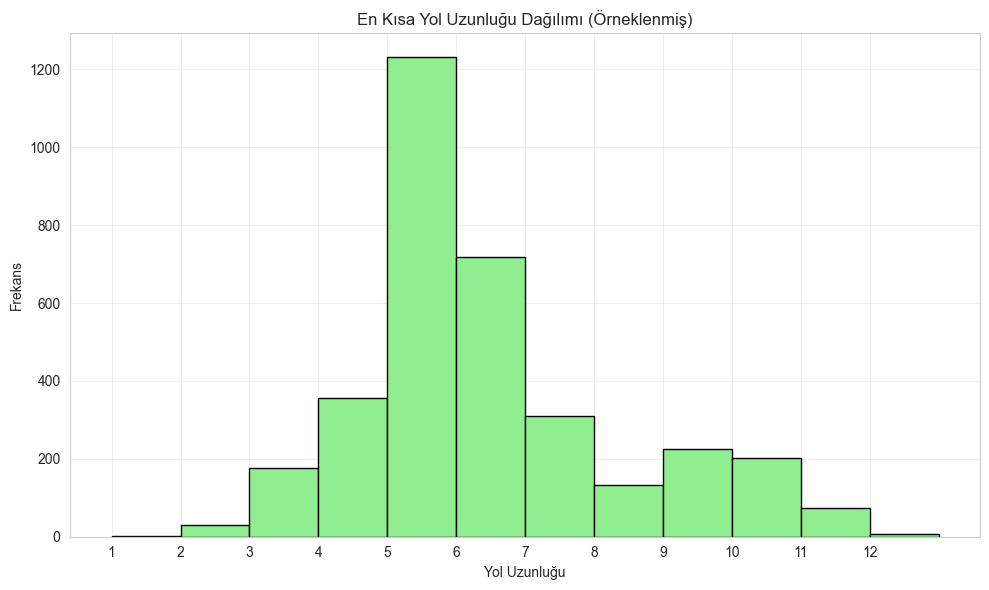

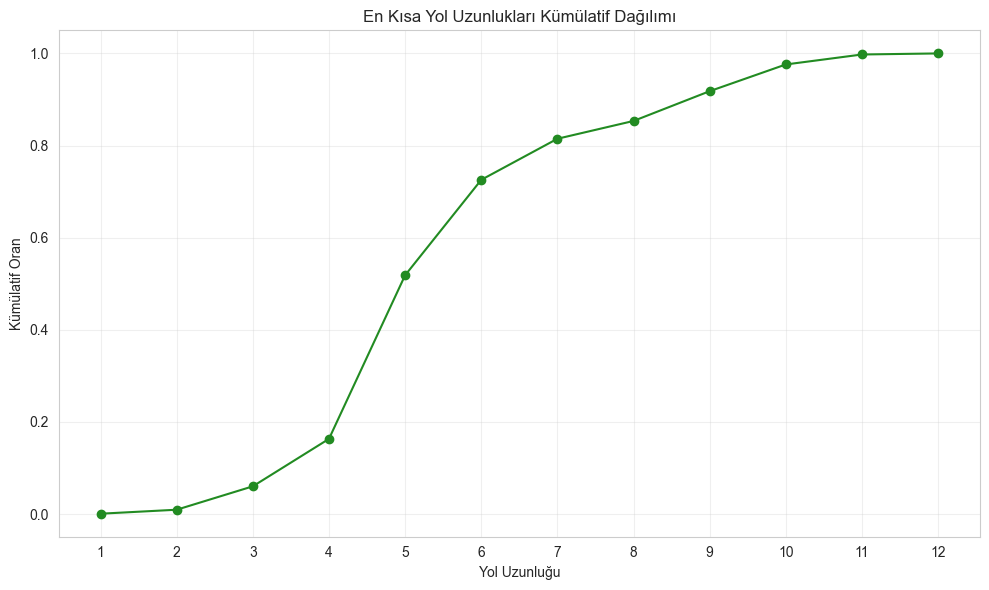

In [16]:
print("Yol analizi yapılıyor...")

sample_size = min(100, G.number_of_nodes())
sampled_nodes = random.sample(list(G.nodes()), sample_size)

path_lengths = []
diameter_paths = []
print(f"{sample_size} düğüm üzerinde en kısa yollar hesaplanıyor...")

for i, u in enumerate(sampled_nodes):
    for v in sampled_nodes[i+1:]:
        try:
            path_length = nx.shortest_path_length(G, u, v)
            path_lengths.append(path_length)
            diameter_paths.append((u, v, path_length))
        except nx.NetworkXNoPath:

            pass

if path_lengths:
    avg_path_length = np.mean(path_lengths)
    max_path_length = max(path_lengths)
    print(f"Örneklenmiş ortalama en kısa yol uzunluğu: {avg_path_length:.4f}")
    print(f"Örneklenmiş çap (en uzun en kısa yol): {max_path_length}")

    max_paths = sorted(diameter_paths, key=lambda x: x[2], reverse=True)[:3]
    print("\nEn uzun yola sahip düğüm çiftleri:")
    for u, v, length in max_paths:
        print(f"Düğüm {u} → Düğüm {v}: {length} adım")
else:
    print("Düğümler arasında hiç yol bulunamadı.")

if path_lengths:
    plt.figure(figsize=(10, 6))
    plt.hist(path_lengths, bins=range(1, max(path_lengths) + 2), color='lightgreen', edgecolor='black')
    plt.title('En Kısa Yol Uzunluğu Dağılımı (Örneklenmiş)')
    plt.xlabel('Yol Uzunluğu')
    plt.ylabel('Frekans')
    plt.grid(True, alpha=0.3)
    plt.xticks(range(1, max(path_lengths) + 1))
    plt.tight_layout()
    plt.show()

if path_lengths:
    values, counts = np.unique(path_lengths, return_counts=True)
    cumulative = np.cumsum(counts) / sum(counts)

    plt.figure(figsize=(10, 6))
    plt.plot(values, cumulative, 'o-', color='forestgreen')
    plt.title('En Kısa Yol Uzunlukları Kümülatif Dağılımı')
    plt.xlabel('Yol Uzunluğu')
    plt.ylabel('Kümülatif Oran')
    plt.grid(True, alpha=0.3)
    plt.xticks(values)
    plt.tight_layout()
    plt.show()

### 3. Benzerlik Analizi
- Benzerlik ölçümleri, düğümler arasındaki yapısal benzerliği değerlendirir
- Jaccard benzerliği, Adamic-Adar indeksi ve tercih bağlantı özellikleri incelenecektir

Benzerlik analizi yapılıyor...
Jaccard benzerliği hesaplanıyor (1000 kenar için)...
Tercih bağlantı analizi yapılıyor...
Derece assortativity katsayısı: -0.106203
Mevcut kenarlar için ortalama Jaccard benzerliği: 0.380477
Var olmayan kenarlar için ortalama Jaccard benzerliği: 0.005592


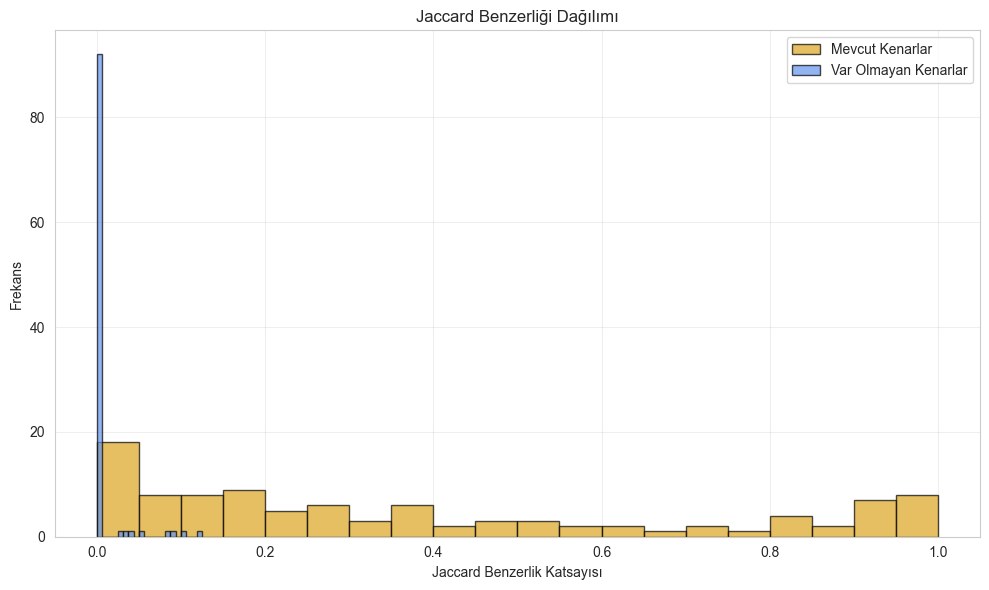

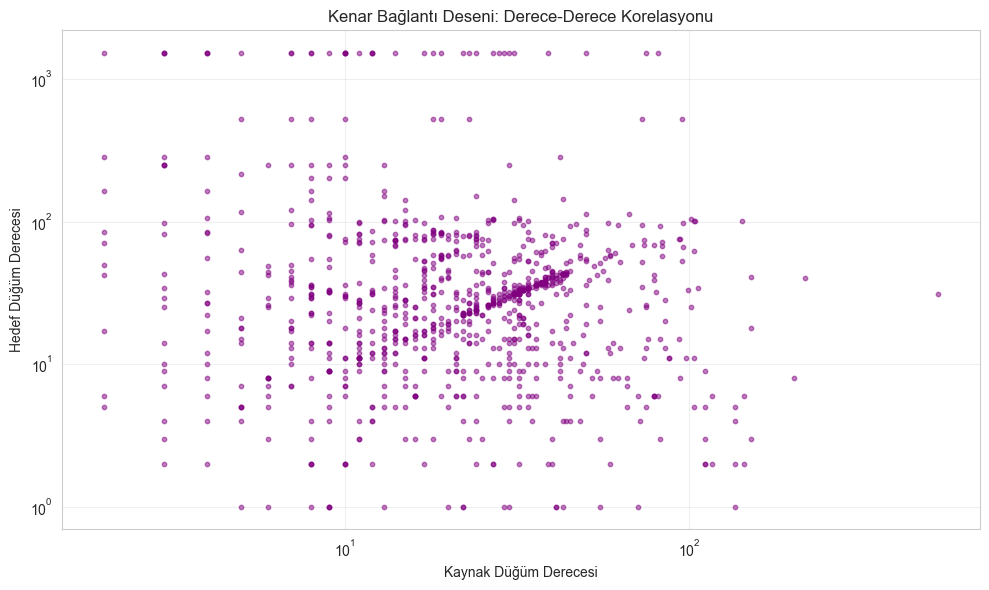

In [17]:
print("Benzerlik analizi yapılıyor...")

edge_sample_size = min(1000, G.number_of_edges())
all_edges = list(G.edges())
non_edges = list(nx.non_edges(G))

random_edges = random.sample(all_edges, edge_sample_size)

non_edge_sample_size = min(edge_sample_size, len(non_edges))
if non_edges and len(non_edges) > non_edge_sample_size:
    random_non_edges = random.sample(non_edges, non_edge_sample_size)
else:
    random_non_edges = non_edges

print(f"Jaccard benzerliği hesaplanıyor ({len(random_edges)} kenar için)...")

jaccard_existing = []
jaccard_non_existing = []

G_undirected = G.to_undirected()

for u, v in random_edges[:100]:
    try:
        neighbors_u = set(G_undirected.neighbors(u))
        neighbors_v = set(G_undirected.neighbors(v))

        # Kendilerini çıkar
        if u in neighbors_v:
            neighbors_v.remove(u)
        if v in neighbors_u:
            neighbors_u.remove(v)

        # Jaccard benzerliği hesapla
        intersection = len(neighbors_u.intersection(neighbors_v))
        union = len(neighbors_u.union(neighbors_v))

        if union > 0:
            jaccard = intersection / union
        else:
            jaccard = 0

        jaccard_existing.append(jaccard)
    except:
        pass

for u, v in random_non_edges[:100]:
    try:
        neighbors_u = set(G_undirected.neighbors(u))
        neighbors_v = set(G_undirected.neighbors(v))

        intersection = len(neighbors_u.intersection(neighbors_v))
        union = len(neighbors_u.union(neighbors_v))

        if union > 0:
            jaccard = intersection / union
        else:
            jaccard = 0

        jaccard_non_existing.append(jaccard)
    except:
        pass

print(f"Tercih bağlantı analizi yapılıyor...")

assortativity = nx.degree_assortativity_coefficient(G)
print(f"Derece assortativity katsayısı: {assortativity:.6f}")

if jaccard_existing:
    print(f"Mevcut kenarlar için ortalama Jaccard benzerliği: {np.mean(jaccard_existing):.6f}")
if jaccard_non_existing:
    print(f"Var olmayan kenarlar için ortalama Jaccard benzerliği: {np.mean(jaccard_non_existing):.6f}")

plt.figure(figsize=(10, 6))

if jaccard_existing:
    plt.hist(jaccard_existing, bins=20, alpha=0.7, label='Mevcut Kenarlar', color='goldenrod', edgecolor='black')
if jaccard_non_existing:
    plt.hist(jaccard_non_existing, bins=20, alpha=0.7, label='Var Olmayan Kenarlar', color='cornflowerblue', edgecolor='black')

plt.title('Jaccard Benzerliği Dağılımı')
plt.xlabel('Jaccard Benzerlik Katsayısı')
plt.ylabel('Frekans')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

if len(random_edges) > 0:
    degrees = dict(G.degree())
    degree_pairs = [(degrees[u], degrees[v]) for u, v in random_edges]
    x_values, y_values = zip(*degree_pairs)

    plt.figure(figsize=(10, 6))
    plt.scatter(x_values, y_values, alpha=0.5, s=10, c='purple')
    plt.title('Kenar Bağlantı Deseni: Derece-Derece Korelasyonu')
    plt.xlabel('Kaynak Düğüm Derecesi')
    plt.ylabel('Hedef Düğüm Derecesi')
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## PageRank


En Yüksek PageRank Skoruna Sahip İlk 15 Düğüm:
1. Düğüm: 163075, PageRank Skoru: 0.03813696
2. Düğüm: 751384, PageRank Skoru: 0.01000425
3. Düğüm: 804489, PageRank Skoru: 0.00848010
4. Düğüm: 172133, PageRank Skoru: 0.00717179
5. Düğüm: 277876, PageRank Skoru: 0.00561845
6. Düğüm: 109489, PageRank Skoru: 0.00525370
7. Düğüm: 818382, PageRank Skoru: 0.00456808
8. Düğüm: 347085, PageRank Skoru: 0.00426017
9. Düğüm: 394956, PageRank Skoru: 0.00379390
10. Düğüm: 624300, PageRank Skoru: 0.00334852
11. Düğüm: 790474, PageRank Skoru: 0.00312148
12. Düğüm: 638031, PageRank Skoru: 0.00293919
13. Düğüm: 837099, PageRank Skoru: 0.00283506
14. Düğüm: 384666, PageRank Skoru: 0.00277578
15. Düğüm: 766583, PageRank Skoru: 0.00272190


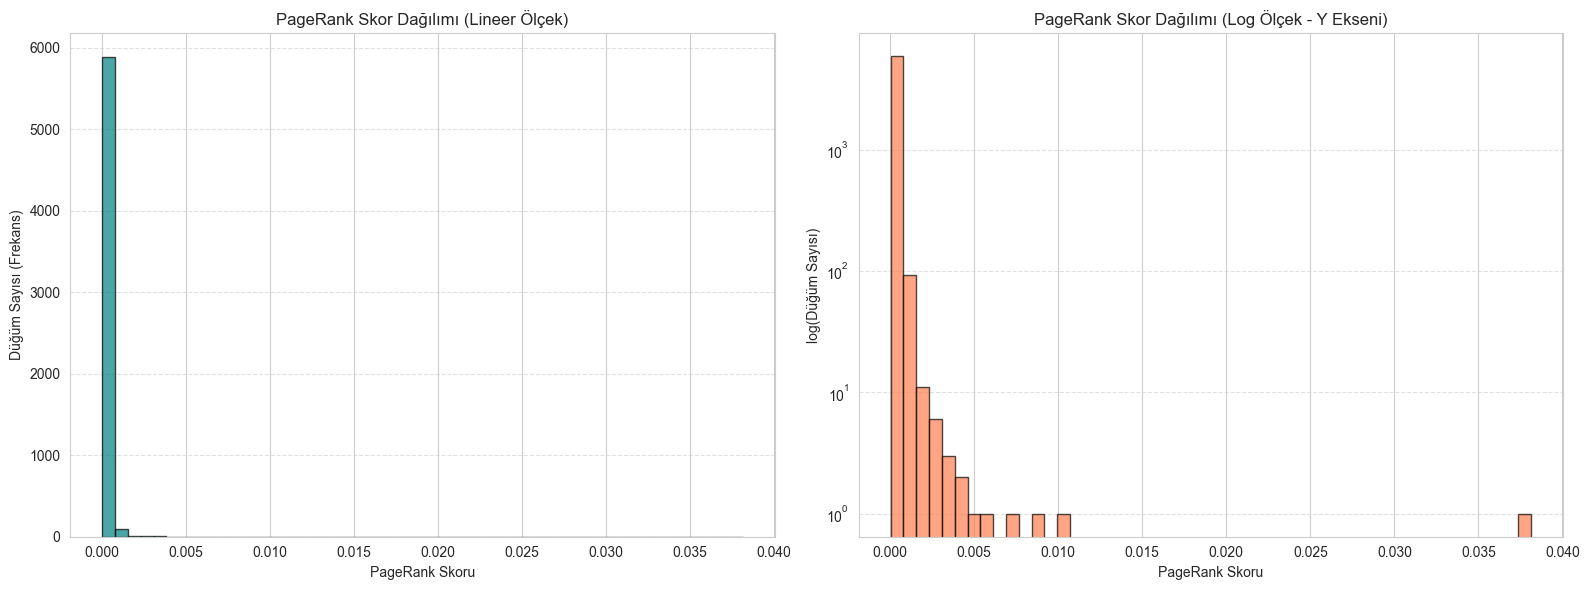

In [18]:
pagerank_scores = nx.pagerank(G, alpha=0.85, max_iter=100, tol=1.0e-6)

num_top_nodes_pr = 15
sorted_pagerank = sorted(pagerank_scores.items(), key=lambda item: item[1], reverse=True)

print(f"\nEn Yüksek PageRank Skoruna Sahip İlk {num_top_nodes_pr} Düğüm:")
for i, (node, score) in enumerate(sorted_pagerank[:num_top_nodes_pr]):
    print(f"{i+1}. Düğüm: {node}, PageRank Skoru: {score:.8f}")

pagerank_values = list(pagerank_scores.values())

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

axs[0].hist(pagerank_values, bins=50, color='teal', alpha=0.7, edgecolor='black')
axs[0].set_title('PageRank Skor Dağılımı (Lineer Ölçek)')
axs[0].set_xlabel('PageRank Skoru')
axs[0].set_ylabel('Düğüm Sayısı (Frekans)')
axs[0].grid(True, axis='y', linestyle='--', alpha=0.6)

non_zero_pagerank_values = [score for score in pagerank_values if score > 0]
if non_zero_pagerank_values:
     axs[1].hist(non_zero_pagerank_values, bins=50, color='coral', alpha=0.7, edgecolor='black')
     axs[1].set_yscale('log') # Y eksenini logaritmik yap
     axs[1].set_title('PageRank Skor Dağılımı (Log Ölçek - Y Ekseni)')
     axs[1].set_xlabel('PageRank Skoru')
     axs[1].set_ylabel('log(Düğüm Sayısı)')
     axs[1].grid(True, axis='y', linestyle='--', alpha=0.6)
else:
     axs[1].text(0.5, 0.5, 'Görselleştirilecek sıfırdan büyük PageRank skoru bulunamadı.',
                 horizontalalignment='center', verticalalignment='center', transform=axs[1].transAxes)
     axs[1].set_title('PageRank Skor Dağılımı (Log Ölçek - Y Ekseni)')
     axs[1].set_xlabel('PageRank Skoru')
     axs[1].set_ylabel('log(Düğüm Sayısı)')


plt.tight_layout()
plt.show()

#### PageRank görselleştirilmesi
- Grafın PageRank'ı yüksek değere sahip olan düğümler daha büyük gözükecek şekilde görselleştirilmesi yapılmıştır. Ayrıca görselleştirmeye komünite renkleri de dahil edilmiştir, bu sayede komünite ve PageRank ilişkisi daha anlaşılabilmektedir.

In [19]:
# G_undirected = G.to_undirected()
# partition = community_louvain.best_partition(G_undirected)
#
# pagerank = nx.pagerank(G)
#
# colors_dict = {}
# size_dict = {}
# communities = {}
#
# for node, community_id in partition.items():
#     if community_id not in communities:
#         communities[community_id] = []
#     communities[community_id].append(node)
#
# counter = 0
# for community_id, nodes in communities.items():
#     color = "#%06X" % randint(0, 0xFFFFFF)
#     counter += 1
#     for node in nodes:
#         colors_dict[node] = color
#
# min_size = 10
# max_size = 125
# min_pagerank = min(pagerank_scores.values())
# max_pagerank = max(pagerank_scores.values())
#
# for node, score in pagerank.items():
#     normalized = (score - min_pagerank) / (max_pagerank - min_pagerank)
#     size_dict[node] = min_size + (max_size - min_size) * (normalized**0.5)
#
# print(f"Number of communities detected: {counter}")
#
# net = Network(height="750px", width="100%",
#              notebook=True,
#              bgcolor="#222222",
#              font_color="white",
#              cdn_resources='in_line')
#
# net.from_nx(G)
#
# net.force_atlas_2based(gravity=-50, central_gravity=0.01, spring_length=100)
#
# # Node özelliklerini uygula
# for node in net.nodes:
#     node_id = node["id"]
#     if node_id in colors_dict:
#         node["color"] = colors_dict[node_id]
#     if node_id in size_dict:
#         node["size"] = size_dict[node_id]
#
#     node["title"] = f"ID: {node_id}<br>PageRank: {pagerank[node_id]:.4f}"
#
# net.options.nodes = {
#     "scaling": {
#         "min": min_size,
#         "max": max_size,
#         "label": {
#             "enabled": True,
#             "min": 14,
#             "max": 30,
#             "drawThreshold": 5
#         }
#     }
# }
#
# net.show("communities_visualization.html")

### Çekirdek-Çevre Analizi

Çekirdek düğüm sayısı: 22
Çevre düğüm sayısı: 5978
Maksimum çekirdek sayısı (k-shell): 42


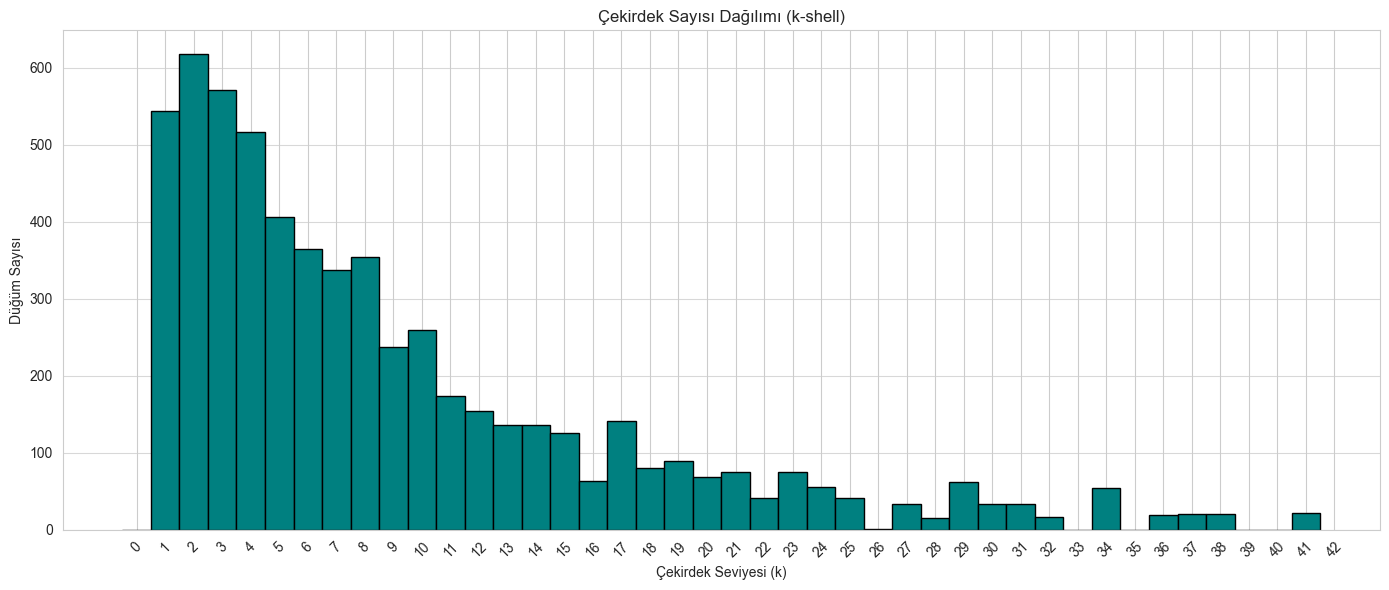

Çekirdek Yoğunluğu: 1.0
Çevre Yoğunluğu: 0.0011276358638749756


In [20]:
core_numbers = nx.core_number(G)
max_core = max(core_numbers.values())

core_nodes = [n for n, k in core_numbers.items() if k == max_core]
periphery_nodes = [n for n, k in core_numbers.items() if k < max_core]

print(f"Çekirdek düğüm sayısı: {len(core_nodes)}")
print(f"Çevre düğüm sayısı: {len(periphery_nodes)}")
print(f"Maksimum çekirdek sayısı (k-shell): {max_core}")

plt.figure(figsize=(14, 6))
plt.hist(core_numbers.values(),
         bins=range(0, max_core+1),  # max_core+1 yeterli
         color='teal', edgecolor='black', align='left')
plt.xticks(range(0, max_core+1), rotation=45)
plt.title("Çekirdek Sayısı Dağılımı (k-shell)")
plt.xlabel("Çekirdek Seviyesi (k)")
plt.ylabel("Düğüm Sayısı")
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()

core_subgraph = G.subgraph(core_nodes)
periphery_subgraph = G.subgraph(periphery_nodes)

core_density = nx.density(core_subgraph)
periphery_density = nx.density(periphery_subgraph)

print("Çekirdek Yoğunluğu:", core_density)
print("Çevre Yoğunluğu:", periphery_density)

### Gephi İçin Veri Dışa Aktarma
Kaynaktan alınmış olan graf ".txt" formatındadır networkx kütüphanesi ile Gephi uygulamasında görüntülenmesi için ".gexf" formatında dışa aktarılması gerekmektedir. Ayrıca bu sayede graf Gephi üzerinde görüntülemek için çok büyük olduğundan "Graf Örnekleme (Graph Sampling)" başlığı altında yapılan işlemler sayesinde örneklendirilmiş graf dışa aktarılabilmektedir.

In [21]:
try:
    nx.write_gexf(G, "web_google_full.gexf")
    print(f"Tam ağ Gephi formatında dışa aktarıldı: web_google_full.gexf")
except Exception as e:
    print(f"Gephi için veri dışa aktarma sırasında hata oluştu: {e}")

Tam ağ Gephi formatında dışa aktarıldı: web_google_full.gexf
